# Overview  <a name='objectives' />

This notebook introduces you to the basics of Neural Networks. We will start by implementing and training a simple neural network using Numpy. Later, we will move on to training fully connected and convolutional neural networks using the PyTorch library.

The topics that will be covered are:

1. <a href=#numpy_nn>Binary Classification with a Simple Neural Network (using Numpy)</a>
2. <a href=#pytorch_basics>PyTorch Basics</a>
3. <a href=#multi>Multiclass Classification with PyTorch</a>
4. <a href=#cnn>Convolutional Neural Networks with PyTorch</a>

### Programming Tasks
For the programming tasks you will need to replace the following comment and exception with your own code:

```python
# YOUR CODE HERE
raise NotImplementedError()
```

Most programming tasks are followed by a cell with tests (using the `assert` function from python). You can use these cells while developing your implementation and for validating your implementation.

**<font size="3" color="red">Note</font>**: The `@contract` decorators make sure the data types and shapes are correct for the inputs and outputs. See [here](https://andreacensi.github.io/contracts/tour.html#quick-tour) for more. If you are more comfortable working without these, you can comment out the lines starting with `@contract`. However, in that case it can get tedious to locate the exact source of a bug.

### Open Questions
The notebook also contains a few open questions. For the open questions you can put your answer in the cell below the question.

In [0]:
# DO NOT INSTALL THE LIBRARIES WHEN WORKING ON ifi-europa.uibk.ac.at

# Make sure that the required libraries are installed
# If you are using Google Colab, remember to upload the requirements file before 
# running this cell
# If you are running this notebook locally, the requirements file needs to be in 
# the same location as this notebook
import os
running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
    
if running_local:
    import sys
    !{sys.executable} -m pip install -r requirements_week06.txt

<a href=#objectives> [go to top] </a>
### Setup

In [0]:
from tqdm.notebook import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')
from contracts import contract
import sklearn
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [0]:
# Random seed for reproducability
random_seed = 123
np.random.seed(random_seed)

# Total number of data points
n_samples = 1500

# Toy dataset
moons = datasets.make_moons(n_samples=n_samples, noise=.35, random_state=random_seed)

You will be working again with the `moons` dataset from `sklearn`. Let's load the data and split it up into train and test sets. The functions for doing this are provided to you below.

In [0]:
# Function for splitting into train and test sets
def split(dataset):
    """
    Splits a dataset from sklearn into train and test sets.
    
    :param: dataset: sklearn dataset (data, labels) (2-tuple of numpy arrays)
    :returns: x_train, x_test, y_train, y_test (4-tuple of numpy arrays)
    """

    # Get data and labels
    X,Y = dataset

    # Reshape Y to [num_points, 1]
    Y = np.expand_dims(Y, axis=1)

    # Split the data into train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=random_seed)
    
    print("Shape of data:")
    print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, Y_train: {Y_train.shape}, Y_test: {Y_test.shape}")
    return X_train, X_test, Y_train, Y_test

In [0]:
moons_x_train, moons_x_test, moons_y_train, moons_y_test = split(moons)

Shape of data:
X_train: (1125, 2), X_test: (375, 2), Y_train: (1125, 1), Y_test: (375, 1)


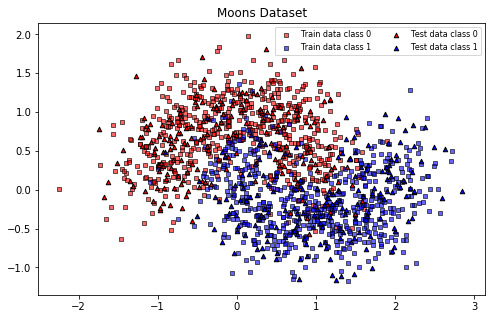

In [0]:
# Visualize the data

plt.figure(figsize=(8,5))

markers = ('s', '^', 'x', 'o', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(moons_y_train))])
    
for idx, yv in enumerate(np.unique(moons_y_train[:,0])): 
    plt.scatter(x=moons_x_train[moons_y_train[:,0]==yv, 0], 
                y=moons_x_train[moons_y_train[:,0]==yv, 1], 
                alpha=0.6, 
                c=[cmap(idx)], 
                marker=markers[0], 
                label=f"Train data class {yv}",
                edgecolors='k',
                s=20)
    
for idx, yv in enumerate(np.unique(moons_y_test[:,0])): 
    plt.scatter(x=moons_x_test[moons_y_test[:,0]==yv, 0], 
                y=moons_x_test[moons_y_test[:,0]==yv, 1], 
                alpha=1.0, 
                c=[cmap(idx)], 
                marker=markers[1], 
                label=f"Test data class {yv}",
                edgecolors='k',
                s=20)

plt.legend(ncol=2, fontsize=8)
plt.title('Moons Dataset')
plt.show()

<a href=#objectives> [go to top] </a>
## Part 1: Binary Classification with a Simple Neural Network (using Numpy) <a name='numpy_nn' />

For this task you will be building and training a simple neural network (consisting of 1 hidden layer) using numpy. A diagram of this simple neural network is provided below, along with the shapes of all the numpy arrays that you will be using. 

In particular, note that data will be fed into the network in batches. For example, in the figure below, the input $X$ is of shape $[m, 2]$, which means that each data point in $X$ is 2-dimensional and there are $m$ such data points (batch size is $m$). $X$ is then combined with the weights $W_1$ and biases $b_1$ to produce the linear output $Z_1$. $Z_1$ is then passed through $g_1$, the activation function of the hidden layer to produce the hidden layer output $A_1$. $A_1$ now forms the input to the output layer, and is combined with $W_2$ and $b_2$ to produce $Z_2$, which is fed in to $g_2$, the activation function of the hidden layer to produce $A_2$, which is the network's prediction for $X$. Since this network will be used for binary classification, $g_2$ is the sigmoid function and $A_2$ has the shape $[m, 1]$.

<img src="https://iis.uibk.ac.at/public/auddy/images/small_net.svg" alt="Image of Neural Network" width="700">

For building and training the network, the following steps need to be performed:
#### Initialize $\rightarrow$ Forward $\rightarrow$ Calculate Loss $\rightarrow$ Backward $\rightarrow$ Weight Update

### Task 1.1: Numpy Network: Initialization

int: (valid_name, int))The first step of building the network shown above is to initialize the weights and biases of the network. For the weights, you need to construct numpy arrays which are initialized randomly. But these random weights should be close to zero (but not all zero). You can use the `np.random.randn` function with the correct shape for this, but `np.random.randn` returns numbers in the range $[-1.0, 1.0]$. If you use exactly the returned values, there is a high chance of numerical overflow while training the network. You will have to modify the returned values so that they are much smaller (e.g. divide by a factor of $100$). For the biases, you can use `np.zeros` with the proper shape. Complete the missing parts of the function `init_model` for initializing the network.

In [0]:
@contract(X='array[MxD],M>0,D>0', 
          Y='array[Mx1],M>0', 
          n_hidden='int,>0')   
def init_model(X, Y, n_hidden):
    """
    Function for initializing the parameters (weights and biases) of our neural network.
    We are working with a network which has 1 hidden layer and 1 output layer.
    
    param: X: Input data (numpy array of shape [m,input_dim])
    param: Y: Target labels (numpy array of shape [m,output_dim])
    param: n_hidden: Number of hidden units (int)

    returns: parameters:  python dictionary containing the initialized parameters:
                          W1 - numpy array of shape (n_hidden, input_dim)
                          b1 - numpy array of shape (1, n_hidden)
                          W2 - numpy array of shape (output_dim, n_hidden)
                          b2 - numpy array of shape (1, output_dim)
    """
    
    # Calculate the number of nodes in the input and output layers
    input_dim = X.shape[1] 
    output_dim = Y.shape[1]

    # Initialize the weights and biases
    # assign to the variables W1, b1, W2 and b2

    ### BEGIN SOLUTION
    
    W1 = np.random.randn(n_hidden, input_dim) * 0.01
    b1 = np.zeros((1, n_hidden))
    W2 = np.random.randn(output_dim, n_hidden) * 0.01
    b2 = np.zeros((1, output_dim))

    ### END SOLUTION

    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2}
    
    return parameters

In [0]:
# Test the init function
m = 250
X = np.random.rand(m, 2)
Y = np.random.rand(m, 1)
n_hidden = 45
parameters = init_model(X, Y, n_hidden)

assert parameters["W1"].shape == (n_hidden, 2), \
f"The shape of W1 is incorrect, it should be ({n_hidden}, 2) but it is {parameters['W1'].shape}"
assert parameters["b1"].shape == (1, n_hidden), \
f"The shape of b1 is incorrect, it should be (1, {n_hidden}) but it is {parameters['b1'].shape}"
assert parameters["W2"].shape == (1, n_hidden), \
f"The shape of W2 is incorrect, it should be (1, {n_hidden}) but it is {parameters['W2'].shape}"
assert parameters["b2"].shape == (1, 1), \
f"The shape of b2 is incorrect, it should be (1, 1) but it is {parameters['b2'].shape}"

### Task 1.2: Numpy Network: Forward Propagation

The steps for forward propagating input data through the network has already been described <a href=#numpy_nn> here</a>. These steps are summarized again below. Complete the functions `sigmoid` for the output activation function. Keep in mind that `sigmoid` should be able to handle both single numbers as well as arrays. Then complete the function `forward_propagation` by implementing these steps:

**Steps for Forward Propagation**

1. $Z_1 = XW_1^{T} + b_{1}$
2. $A_1 = g_{1}(Z_{1})$ (where $g_{1}$ is the activation function of layer 1)
3. $Z_2 = A_{1}W_2^{T} + b_{2}$
4. $A_2 = g_{2}(Z_{2})$ (where $g_{2}$ is the sigmoid function)

Use `np.tanh` for $g_{1}$ and the sigmoid function for $g_{2}$.

In [0]:
@contract(z='array[AxB],A>0,B>0|float',
          returns='array[AxB],A>0,B>0|float,>=0.0,<=1.0')
def sigmoid(z):
    """
    Computes the sigmoid function. 
    Capable of vectorizing (works for both single floats as well as numpy arrays)
    
    param: z: Input (float or numpy array)
    returns: Sigmoid of input (float or numpy array)
    """
    
    ### BEGIN SOLUTION
    sigmoid_value = 1.0 / (1.0 + np.exp(-z))
    ### END SOLUTION
    
    return sigmoid_value

In [0]:
@contract(X='array[MxD],M>0,D>0')
def forward_propagation(X, parameters):
    """
    Forward-propagates the data through the neural network
    
    param: X: Input data (numpy array of shape [m,input_dim])
    param: python dictionary containing the initialized parameters:
                          W1 - numpy array of shape (n_hidden, input_dim)
                          b1 - numpy array of shape (1, n_hidden)
                          W2 - numpy array of shape (output_dim, n_hidden)
                          b2 - numpy array of shape (1, output_dim)
    
    returns: A2: The network prediction (numpy array of shape [m,output_dim])
             cache: python dictionary containing Z1, A1, Z2 and A2
    """
    
    # Retrieve weights and biases
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    #   assign to variables Z1, A1, Z2, A2
    #
    #   use `np.tanh` for A1
    #   use the `sigmoid` function for A2
    
    ### BEGIN SOLUTION
    
    Z1 = np.dot(X,W1.T) + b1
    A1 = np.tanh(Z1)  # Use the np.tanh function here
    Z2 = np.dot(A1, W2.T) + b2
    A2 = sigmoid(Z2)  # Use the sigmoid function here
    
    ### END SOLUTION
        
    cache = {'Z1': Z1,
             'A1': A1,
             'Z2': Z2,
             'A2': A2}
    
    return A2, cache  # Think: Why do we return the cache?

In [0]:
# Test the forward function using the variables from the previous test block
A2, cache = forward_propagation(X, parameters)

assert A2.shape == (X.shape[0], 1), \
f"The shape of A2 is incorrect, it should be ({X.shape[0]}, 1) but it is {A2.shape}"

assert cache["Z1"].shape == (m, n_hidden), \
f"The shape of cache['Z1'] is incorrect, it should be ({m}, {n_hidden}) but it is {cache['Z1'].shape}"

assert cache["A1"].shape == (m, n_hidden), \
f"The shape of cache['A1'] is incorrect, it should be ({m}, {n_hidden}) but it is {cache['A1'].shape}"

assert cache["Z2"].shape == (m, 1), \
f"The shape of cache['Z2'] is incorrect, it should be ({m}, 1) but it is {cache['Z2'].shape}"

assert cache["A2"].shape == (m, 1), \
f"The shape of cache['A2'] is incorrect, it should be ({m}, 1) but it is {cache['A2'].shape}"


### Task 1.3: Numpy Network: Binary Cross Entropy Loss
Complete the function `loss` which computes the binary cross entropy loss $J$, given by the following formula:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small Y^{(i)}\log\left(A_{2}^{(i)}\right) + (1-Y^{(i)})\log\left(1- A_{2}^{(i)}\right) \large{)} \small$$

where $m$ is the number of data points, $Y^{(i)}$ is the $i^{\text{th}}$ target label, and $A_{2}^{(i)}$ is the $i^{\text{th}}$ prediction.

**Hint**: Since $\log(0) \rightarrow \infty$ use of the logarithm might lead to numerical issues (for example for very small numbers). To avoid this issue, add small number `eps` in the log functions $\log(x + \mathrm{eps})$.

In [0]:
@contract(A2='array[MxO],M>0,O>0',
          Y='array[MxO],M>0,O>0',
          returns='float, >=0')
def loss(A2, Y, params):
    """
    Computes the binary cross entropy loss
    
    param: A2: The network prediction (numpy array of shape [m,output_dim])
    param: Y: Target labels (numpy array of shape [m,output_dim])
    param: params: python dictionary containing parameters W1, b1, W2 and b2
    
    returns: loss: cross-entropy loss (float)
    """
    
    eps = 1e-15
    
    # Number of data points
    num_data_points = Y.shape[0]
    
    # Compute the cross-entropy loss
    #
    #   Make sure to return a scalar!

    ### BEGIN SOLUTION

    logprobs = np.multiply(Y, np.log(A2 + eps)) + np.multiply(1.0 - Y, np.log(1.0 - A2 + eps))
    loss_value = -np.sum(logprobs)/num_data_points    
    loss_value = np.squeeze(loss_value).astype(np.float)

    ### END SOLUTION
    
    return loss_value

In [0]:
# Test the loss function
loss_value = loss(A2, Y, parameters)
assert isinstance(loss_value, float) and loss_value>=0.0, "loss_value should be a float >= 0.0"

### Numpy Network: Backward Propagation
The backward function is used for computing the gradients of the trainable parameters (the weights and the biases) of the network. The steps for the backward computation are provided below. These formulas were derived assuming that $g_{2}$, the output activation function is sigmoid. All the symbols have the same meaning as in earlier cells. The backward function is provided to you, but you are encouraged to study and understand it.

A detailed proof is provided [here](https://iis.uibk.ac.at/public/auddy/proof/Backpropagation_Proof.pdf).

**Steps for Backward Propagation**

where $\odot$ denotes the Hadamard product.

($\text{d}Z_{2}$ stands for $\cfrac{\partial{J}}{\partial{Z_{2}}}$ and so on)
1. $\text{d}Z_{2} = A_{2} - Y$ (assuming sigmoid function is used in the output layer)
2. $\text{d}W_{2} = \cfrac{1}{m} \text{d}Z_{2}^{T} A_{1}$
3. $\text{d}b_{2} = \cfrac{1}{m}$np.sum($\text{d}Z_{2}$, axis=0, keepdims=True)
4. $\text{d}Z_{1} = (\text{d}Z_{2}W_{2})  \odot (g'_{1}(Z_{1}))$
5. $\text{d}W_{1} = \cfrac{1}{m} \text{d}Z_{1}^{T}X$
6. $\text{d}b_{1} = \cfrac{1}{m}$np.sum($\text{d}Z_{1}$, axis=0, keepdims=True)

In [0]:
def backward_propagation(parameters, cache, X, Y):
    """
    Backward function for computing gradients

    param: parameters: python dictionary containing parameters W1, b1, W2 and b2
    param: cache: python dictionary containing Z1, A1, Z2 and A2
    param: X: Input data (numpy array of shape [m,input_dim])
    param: Y: Target labels (numpy array of shape [m,output_dim])
    
    returns: grads: python dictionary containing gradients dW1, db1, dW2 and db2
    """
    
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary 'parameters'
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    # Retrieve also A1 and A2 from dictionary 'cache'
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2.T, A1)/m
    db2 = np.sum(dZ2, axis=0, keepdims=True)/m
    dZ1 = np.multiply(np.dot(dZ2, W2), (1 - np.power(A1, 2)))
    dW1 = np.dot(dZ1.T, X)/m
    db1 = np.sum(dZ1, axis=0, keepdims=True)/m
    
    grads = {'dW1': dW1,
             'db1': db1,
             'dW2': dW2,
             'db2': db2}
    
    return grads

### Task 1.4: Numpy Network: Updating Weights
After the gradient computation, the weights and biases need to be updated in the direction of the negative gradient by using the learning rate. The weight update is done using the following formula:
$$ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$$ 
where $\alpha$ is the learning rate and $\theta$ represents a trainable parameter (weight or bias).

Complete the function `update_parameters` for performing weight updates.

In [0]:
def update_parameters(parameters, grads, learning_rate = 0.01):
    """
    Updates parameters using the gradient descent update rule given above
    
    param: parameters: python dictionary containing parameters W1, b1, W2 and b2
    param: grads: python dictionary containing gradients dW1, db1, dW2 and db2
    
    returns: parameters: python dictionary containing updated parameters W1, b1, W2 and b2 
    """
    
    # Steps:
    #   1. Retrieve each parameter (W1, b1, W2, b2) from the dictionary "parameters"
    #   2. Retrieve each gradient (dW1, db1, dW2, db2) from the dictionary "grads"
    #   3. Update each parameter (W1, b1, W2, b2)
    
    ### BEGIN SOLUTION
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    ### END SOLUTION
    
    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2}
    
    return parameters

In [0]:
# Test the update function
grads = backward_propagation(parameters, cache, X, Y)
updated_parameters = update_parameters(parameters, grads, learning_rate = 0.01)

for k, v in parameters.items():
    assert updated_parameters[k].shape == v.shape, \
    f"Shape of updated_parameters['{k}']: {updated_parameters[k].shape} is not equal to shape of parameters['{k}']: {v.shape}"

### Task 1.5: Numpy Network: Accuracy and Prediction

Complete the functions `predict` for making predictions and `calc_accuracy` for computing the accuracy of predictions. The prediction function should assign outputs of the network which are $> 0.5$ to class $1$ and the rest to class $0$.

In [0]:
@contract(X='array[MxD],M>0,D>0',
          returns='array[Mx1],M>0')
def predict(parameters, X):
    """
    Make predictions (class 0 or 1) using the learned parameters
    
    param: parameters: python dictionary containing parameters W1, b1, W2 and b2
    param: X: Input data for which label is to be predicted (numpy array of shape [m,input_dim])
        
    returns: predictions: Predictions of our model (numpy array of shape [m,1] containing 0s and 1s)
    """
    
    # Compute probabilities using forward propagation, and classify to 0/1 using 0.5 as the threshold.
    
    ### BEGIN SOLUTION
    
    A2, cache = forward_propagation(X, parameters)
    predictions = A2 > 0.5
    
    ### END SOLUTION
    
    return predictions.astype(int)

In [0]:
# Test the predict function
predictions = predict(parameters, X)

assert predictions.shape == (X.shape[0], 1), \
f"Shape of predictions is {predictions.shape}, but it must be {(X.shape[0], 1)}"

# only labels 0, 1 are allowed
assert set(np.unique(predictions)).issubset(set([0, 1])), \
f"Predictions can only contain 0s and 1s but they contain {np.unique(predictions)}"  

In [0]:
@contract(Y_pred='array[Mx1],M>0',
          Y='array[Mx1],M>0',
          returns='float,>=0.0,<=1.0')
def calc_accuracy(Y_pred, Y):
    """
    Calculates the accuracy of the predictions against the true labels
    (What percent of the predicted labels Y_pred matches the true labels in Y)
    
    param: Y_pred: Predictions of our model (numpy array of shape [m,1] containing 0s and 1s)
    param: Y: Target labels (numpy array of shape [m,output_dim])
    
    returns: accuracy (float between 0.0 and 1.0)
    
    """
    ### BEGIN SOLUTION
    
    accuracy = float(np.dot(Y.T,Y_pred) + np.dot((1-Y).T,1-Y_pred))/float(Y.size)
    
    ### END SOLUTION
    
    return accuracy

In [0]:
# Test the accuracy function
accuracy = calc_accuracy(A2, Y)
assert isinstance(accuracy, float) and accuracy >= 0.0 and accuracy <= 1.0, \
"Accuracy must be a float between 0.0 and 1.0"

### Task 1.6: Numpy Network: Putting Everything Together

The function `train_neural_network` uses batch gradient descent (entire training data is used at the same time to compute gradients) for training our numpy neural network. Complete this function by using the functions that you have implemented till now.

In [0]:
@contract(X_train='array[MxD],M>0,D>0',
          Y_train='array[Mx1],M>0',
          n_hidden='int,>0',
          learning_rate='float,>0.0',
          num_iterations='int,>0')
def train_neural_network(X_train, Y_train, n_hidden, learning_rate=0.01, num_iterations = 10000):
    """
    Trains the network using batch gradient descent
    
    param: X_train: Training data (numpy array of shape [m,input_dim])
    param: Y_train: Training data labels (numpy array of shape [m,output_dim])
    param: n_hidden: Number of neurons in the hidden layer (int)
    param: num_iterations: Number of iterations in gradient descent loop (int)
    param: learning_rate: Learning rate for gradient descent (float)
    
    returns: parameters: Learned parameters - python dictionary containing W1, b1, W2 and b2
    """
    
    losses = list()
    
    
    # Follow these steps:
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. 
    # For each iteration (till `num_iterations` is reached):
    #     Forward propagation: Compute A2, cache using `X_train` and `parameters`
    #     Loss. Inputs: `A2`, `Y_train`, `parameters`. Outputs: `loss_value`. Append `loss_value` to `losses`
    #     Backpropagation. Inputs: `parameters`, `cache`, `X_train`, `Y_train`. Outputs: `grads`
    #     Parameter update. Inputs: `parameters`, `grads`, `learning_rate`. Outputs: `parameters`
    
    ### BEGIN SOLUTION
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. 
    parameters = init_model(X_train, Y_train, n_hidden)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Loop
    for i in trange(0, num_iterations):
         
        # Forward propagation
        A2, cache = forward_propagation(X_train, parameters)
        
        # Loss function. Inputs: "A2, Y_train, parameters". Outputs: "loss_value"
        loss_value = loss(A2, Y_train, parameters)
        losses.append(loss_value)
 
        # Backpropagation. Inputs: "parameters, cache, X_train, Y_train". Outputs: "grads"
        grads = backward_propagation(parameters, cache, X_train, Y_train)
 
        # Gradient descent parameter update. Inputs: "parameters, grads, learning_rate". Outputs: "parameters"
        parameters = update_parameters(parameters, grads, learning_rate)

    ### END SOLUTION

    return parameters, losses

In [0]:
# Lets train a network with 3 units in the hidden layer using the moon dataset
params_moons_3, losses_moons_3 = train_neural_network(moons_x_train, 
                                                      moons_y_train,
                                                      3, 
                                                      learning_rate=0.01, 
                                                      num_iterations=10000)

In [0]:
def plot_decision_boundary_nn(ax, predict_fn, params, X_train, Y_train, X_test, Y_test, cmap='coolwarm'):
    """
    Plots the decision boundary predicted by the neural network
    Don't worry about the details of this function
    """
    
    markers = ('s', '^', 'x', 'o', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(Y_train))])

    # For constructing the grid limits
    h = 0.02
    x_min, x_max = X_train[:,0].min() - 10*h, X_train[:,0].max() + 10*h
    y_min, y_max = X_train[:,1].min() - 10*h, X_train[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Make predictions for each value inside the grid and reshape
    Z = predict_fn(params, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    cs = ax.contour(xx, yy, Z, colors='k', alpha=1.0)
    cs.collections[0].set_label("Decision boundary")
    
    for idx, yv in enumerate(np.unique(Y_train[:,0])): 
        ax.scatter(x=X_train[Y_train[:,0]==yv, 0], 
                    y=X_train[Y_train[:,0]==yv, 1], 
                    alpha=0.6, 
                    c=[cmap(idx)], 
                    marker=markers[0], 
                    s=20,
                    label=f"Train data class {yv}",
                    edgecolors='k')

    for idx, yv in enumerate(np.unique(Y_test[:,0])): 
        ax.scatter(x=X_test[Y_test[:,0]==yv, 0], 
                    y=X_test[Y_test[:,0]==yv, 1], 
                    alpha=0.6, 
                    c=[cmap(idx)], 
                    marker=markers[1], 
                    s=20,
                    label=f"Test data class {yv}",
                    edgecolors='k')
    ax.legend(ncol=2, fontsize=8)

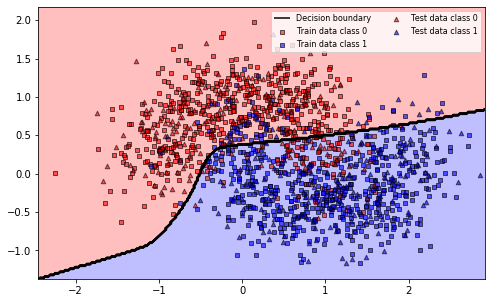

In [0]:
# Plot the decision boundary for network we just trained
fig, ax = plt.subplots(1,1,figsize=(8,5))
plot_decision_boundary_nn(ax, 
                          predict, 
                          params_moons_3, 
                          moons_x_train, 
                          moons_y_train, 
                          moons_x_test, 
                          moons_y_test)

In [0]:
# Now,let us train different networks with different number of hidden units
# If it takes too long, you can also try out values smaller than 100

hidden = [5, 10, 30, 100]
params_moons_dict = dict()

for h in hidden:
    print(f"Training for hidden size {h}")
    params, losses = train_neural_network(moons_x_train, 
                                          moons_y_train, 
                                          h, 
                                          learning_rate=0.01, 
                                          num_iterations=10000)
    
    train_acc = calc_accuracy(predict(params, moons_x_train), moons_y_train)
    test_acc = calc_accuracy(predict(params, moons_x_test), moons_y_test)

    params_moons_dict[h] = {"params": params, 
                            "losses": losses,
                            "train_acc": train_acc,
                            "test_acc": test_acc}

Training for hidden size 5



Training for hidden size 10



Training for hidden size 30



Training for hidden size 100


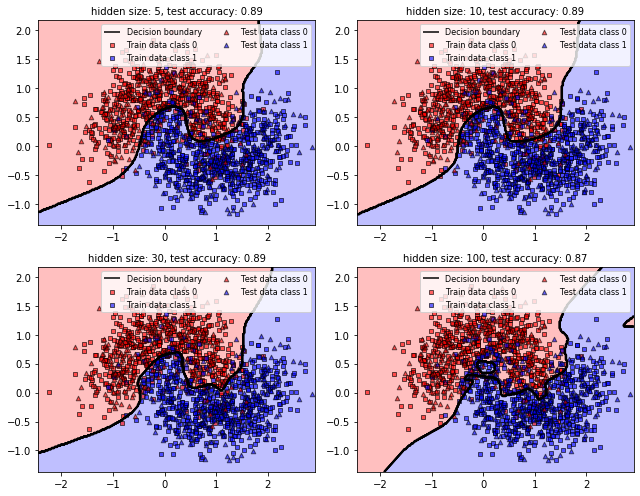

In [0]:
# Plotting the decision boundaries for the different networks that were trained

fig, ax = plt.subplots(2, 2, figsize=(9,7))

for i, (h, value) in enumerate(params_moons_dict.items()):
    r = i//2
    c = i%2
    plot_decision_boundary_nn(ax[r][c],  
                              predict, 
                              value["params"], 
                              moons_x_train, 
                              moons_y_train, 
                              moons_x_test, 
                              moons_y_test)
    ax[r][c].set_title(f"hidden size: {h}, test accuracy: {value['test_acc']:.2f}",
                       fontsize=10)
plt.tight_layout()   

If everything goes well, you should be able to observe that as the number of hidden units is increased, the decision boundary becomes highly non-linear. For high number of hiddent units, it can be seen that the classifier overfits the training data.

**Hint**: If for some network, the decision boundary appears as a straight line, it may be because that network was not able to learn. Try changing the hyperparameters, such as the number of hidden units, the learning rate, or the number of iterations, and try again. You should be able to see plots similar to [this](https://ibb.co/ZY7G0wd).

<a href=#objectives> [go to top] </a>

## Part 2: PyTorch Basics <a name='pytorch_basics' />

[PyTorch](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a Python-based scientific computing library that is commonly used for deep learning. It provides helpful features such as automatic differentitaion, the ability to utilize GPUs, and a large collection of deep-learning related algorithms. There are several other alternatives to PyTorch, such as Tensorflow or Caffe, but for this notebook, you will be using PyTorch. 

**If you are unfamiliar with PyTorch, we recommend you work through the [PyTorch 60minutes Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) first.** 

For the exercises below, no prior knowledge of PyTorch is assumed.

Visit [this link](https://pytorch.org/tutorials/index.html) for some PyTorch tutorials.

First, let us use the same dataset that was used till now, but this time you will create a multilayered fully connected neural network using PyTorch for classifying the points of the dataset.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

# Check https://pytorch.org/docs/stable/notes/randomness.html#reproducibility
torch.manual_seed(random_seed)


### Task 2.1: PyTorch Basics: Network Definition

Given below is the class definition for a fully connected network with 2 hidden layers and 1 output layer. Complete the missing parts. Comments are provided to guide you. **It may be helpful to get acquainted with the [different activation functions in PyTorch ](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions).** The module is imported as `F`.

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Follow these steps:
        #
        # Flatten the input x keeping the batch dimension the same
        # Use the relu activation on the output of self.fc1(x)
        # Use the relu activation on the output of self.fc2(x)
        # Pass x through fc3 but do not apply any activation function (why not?)
        
        
        ### BEGIN SOLUTION
        x = x.view(-1, self.input_size)  
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = self.fc3(x)          
        ### END SOLUTION
        return x  # Return x (logits)

In [0]:
# Verify the network class
testnet = Net(2, 20, 1)
ip = torch.rand((350,2))
# This is not the best way to pass the data through the net
# In the next task you will need to find the better way
op = testnet.forward(ip)  
assert op.shape==(350,1), f"Output shape must be (350,1) but it is {op.shape}"

### Task 2.2: PyTorch Basics: Training

Once the network is defined, it can be trained by following roughly the same sequence of steps as the numpy network you trained earlier. This is done in the function `train_neural_network_pytorch` given below. Complete the missing parts of this function.

**Note**: 
* The weights and biases of the network are initialized when the network object is created (outside the training function)
* PyTorch operates on [Tensors](https://pytorch.org/docs/stable/tensors.html) which are multi-dimensional matrices containing elements of a single data type. Although tensors look similar to numpy arrays, they have several additional properties. Therefore, any data or labels that are used with a PyTorch network need to be converted into Tensors. 
* PyTorch includes a large number of training algorithms (optimizers) for training networks. See [here for details of how to use an optimizer](https://pytorch.org/docs/stable/optim.html) and their different types. The code for using an optimizer for this notebook is provided to you.
* Several types of loss functions (**criterion**) [are also available](https://pytorch.org/docs/stable/nn.html#loss-functions).

In [0]:
# Define hyperparameters
LEARNING_RATE = 0.001
MOMENTUM = 0.9
MAX_ITERATIONS = 10000
INPUT_SIZE = 2
HIDDEN_SIZE = 20
OUTPUT_SIZE = 1

We use the [BCEWithLogitsLoss function](https://pytorch.org/docs/stable/nn.html#torch.nn.BCEWithLogitsLoss) so familiarize yourself with this type of function.

In [0]:
# Initialize the network
net = Net(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

# Define the loss criterion and the training algorithm
criterion = nn.BCEWithLogitsLoss()  # Be careful, use binary cross entropy for binary, CrossEntropy for Multi-class
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [0]:
def train_neural_network_pytorch(net, inputs, labels, optimizer, criterion, iterations=10000):
    """
    :param net: the neural network object
    :param inputs: numpy array of training data values
    :param labels: numpy array of training data labels 
    :param optimizer: PyTorch optimizer instance
    :param criterion: PyTorch loss function
    :param iterations: number of training steps
    """
    net.train()  # Before training, set the network to training mode

    for iter in trange(iterations):  # loop over the dataset multiple times

        # It is a common practice to track the losses during training
        # Feel free to do so if you want
        
        # Get the inputs; data is a list of [inputs, labels]
        # Convert to tensors if data is in the form of numpy arrays
        if not torch.is_tensor(inputs):
            inputs = torch.from_numpy(inputs.astype(np.float32)) 
            
        if not torch.is_tensor(labels):
            labels = torch.from_numpy(labels.astype(np.float32))

            
        # Follow these steps:
        # 1. Reset gradients: Zero the parameter gradients (Check the link for optimizers in the text cell 
        #                     above to find the correct function)
        # 2. Forward: Pass `inputs` through the network. This can be done calling 
        #             the `forward` function of `net` explicitly but there is an 
        #             easier way that is more commonly used
        # 3. Compute the loss: Use `criterion` and pass it the `outputs` and `labels`
        #                      Check the link in the text cell above for details
        # 4. Backward: Call the `backward` function in `loss`
        # 5. Update parameters: This is done using the optimizer's `step` function. 
        #                       Check the link provided for details.
        
        ### BEGIN SOLUTION
             
        optimizer.zero_grad()  
        
        outputs = net(inputs)
             
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        ### END SOLUTION 
        
    print('Finished Training')

### Task 2.3: PyTorch Basics: Activation Function after Final FC layer output

In the `forward` function of the `Net` class, we did not use any non-linear activation function on the final output. Why?

Your answer:

Without any activation function, the output of the forward function are the logits. This was done since the criterion we have used is `BCEWithLogitsLoss`, which applies log and sigmoid to the logits and then computes the binary cross entropy with the target labels. If we had used the sigmoid activation on the final output, we could have used the `BCELoss` loss instead. However, `BCEWithLogitsLoss` is preferred over `BCELoss` because it is numerically more stable.

In [0]:
# Check the network stats
summary(net, input_size=(2,), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              60
            Linear-2                   [-1, 20]             420
            Linear-3                    [-1, 1]              21
Total params: 501
Trainable params: 501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Task 2.4: PyTorch Basics: Verify Number of Trainable Parameters

The `summary` function from `torchsummary` is useful for finding the statistics of network parameters layers and output shapes. Calculate the number of parameters for each layer ($W$ and $b$ separately) by hand and verify your result with the number of parameters shown in the cell above.

How many parameters are there?

 - Layer 1 (first hidden layer): Weights = ...
 - Layer 1 (first hidden layer): Bias = ...
 ...

Total = ?

Your answer:

* Layer 1 (first hidden layer): Weights [2,20]    = 40
* Layer 1 (first hidden layer): biases [1,20]     = 20
* Layer 2 (second hidden layer): Weights [20,20]  = 400
* Layer 2 (second hidden layer): biases [1,20]    = 20
* Layer 3 (output layer): Weights [20,1]          = 20
* Layer 3 (output hidden layer): biases [1,1]     = 1
* Total                                           = 501

In [0]:
# Train the PyTorch network
train_neural_network_pytorch(net, moons_x_train, moons_y_train, optimizer, criterion, MAX_ITERATIONS)


Finished Training


In [0]:
def predict_pytorch(net, X):
    """
    Function for producing network predictions
    """
    
    net.eval()
    
    # Make predictions (class 0 or 1) using the learned parameters
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    X = torch.from_numpy(X.astype(np.float32))
    logits = net(X)
    predictions = torch.sigmoid(logits) > 0.5
    
    return predictions

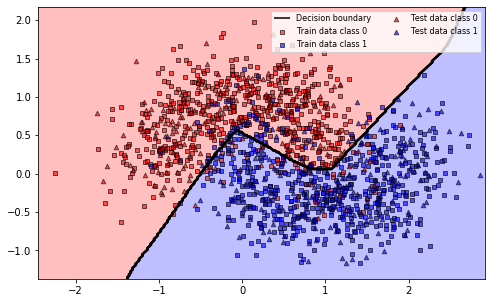

In [0]:
# Plot the decision boundary learned by the neural network
fig, ax = plt.subplots(1,1,figsize=(8,5))
plot_decision_boundary_nn(ax, 
                          predict_pytorch, 
                          net, 
                          moons_x_train, 
                          moons_y_train, 
                          moons_x_test, 
                          moons_y_test)

In [0]:
# Calculate the accuracies on the training and test data
# You should be able to get accuracies around 0.9
train_acc = calc_accuracy(predict_pytorch(net, moons_x_train).data.numpy(), moons_y_train)
test_acc = calc_accuracy(predict_pytorch(net, moons_x_test).data.numpy(), moons_y_test)
print(f"Train accuracy: {train_acc:.2f}, Test accuracy: {test_acc:.2f}")

assert train_acc>0.8 and test_acc>0.8, "Rerun with different hyperparameters to get better accuracies"

Train accuracy: 0.90, Test accuracy: 0.89


In [0]:
# Let us again train different networks with different number of hidden units
# You can also experiment with larger sizes for the hidden units by using bigger numbers in the `hidden` list

hidden = [10, 20, 30, 50]
pytorch_moons_dict = dict()

for h in hidden:
    net = Net(INPUT_SIZE, h, OUTPUT_SIZE)
    optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    print(f"Training for hidden size {h}")
    
    train_neural_network_pytorch(net, 
                                 moons_x_train, 
                                 moons_y_train, 
                                 optimizer, 
                                 criterion, 
                                 iterations=10000)
    
    train_acc = calc_accuracy(predict_pytorch(net, moons_x_train).data.numpy(), moons_y_train)
    test_acc = calc_accuracy(predict_pytorch(net, moons_x_test).data.numpy(), moons_y_test)

    pytorch_moons_dict[h] = {"net": net, 
                             "train_acc": train_acc,
                             "test_acc": test_acc}

Training for hidden size 10



Finished Training
Training for hidden size 20



Finished Training
Training for hidden size 30



Finished Training
Training for hidden size 50



Finished Training


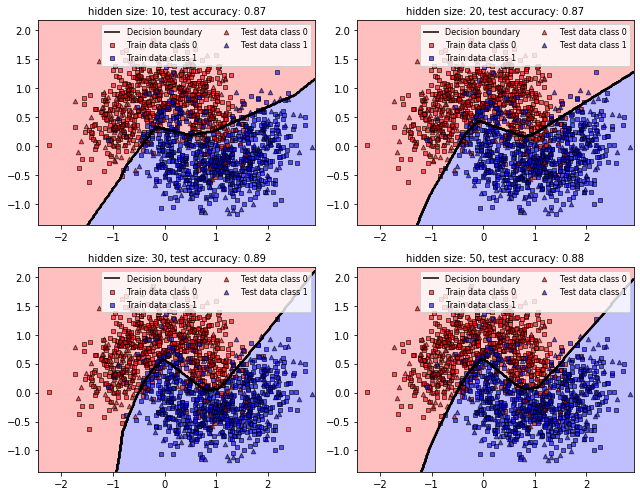

In [0]:
# Plot decision boundaries for the different networks

fig, ax = plt.subplots(2, 2, figsize=(9,7))
for i, (h, value) in enumerate(pytorch_moons_dict.items()):
    r = i//2
    c = i%2
    plot_decision_boundary_nn(ax[r][c], 
                              predict_pytorch, 
                              value["net"], 
                              moons_x_train, 
                              moons_y_train, 
                              moons_x_test, 
                              moons_y_test)
    ax[r][c].set_title(f"hidden size: {h}, test accuracy: {value['test_acc']:.2f}",
                       fontsize=10)
plt.tight_layout()

<a href=#objectives> [go to top] </a>
## Part 3: Multiclass Classification with PyTorch <a name='multi' />

Till now, we had been training networks for performing binary classification. Now, we move on to the problem of multiclass classification, where for a given input, the network needs to predict one out of $C$ possible classes. Additionally, till now, we had been training the network using batch gradient descent, where the entire training dataset is used to compute gradients in each iteration. Now, we will use minibatch gradient descent, where a minibatch (smaller subset of the train set) is used in each iteration.

In [0]:
from torchvision import datasets, transforms

For this part of the notebook, and the next, we will be using the [MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist) dataset from [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html). First, we need to cteate dataset objects for the training and test data. The first time the next cell is run, the data is downloaded and stored in the `data` directory. Standard transformations are applied to the data tenstors.

In [0]:
train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=running_local,
                               transform=transforms.Compose([transforms.ToTensor(),
                                                             transforms.Normalize((0.1307,), (0.3081,))
                                                            ]))

test_dataset = datasets.MNIST('./data', 
                              train=False, 
                              transform=transforms.Compose([transforms.ToTensor(),
                                                            transforms.Normalize((0.1307,), (0.3081,))
                                                           ]))


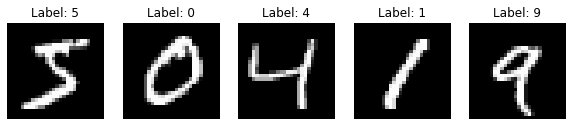

In [0]:
# View sample data and targets
fig, ax = plt.subplots(1,5,figsize=(10,2))
for i in range(5):
    ax[i].imshow(train_dataset[i][0].data.numpy().squeeze(0), cmap='gray')
    ax[i].set_title(f"Label: {train_dataset[i][1]}")
    ax[i].axis('off')

In [0]:
# Define hyperparameters
LEARNING_RATE = 0.001
MOMENTUM = 0.9
NUM_EPOCHS = 3
HIDDEN_SIZE = 200
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 100
INPUT_SIZE = 784  # Do not change this
HIDDEN_SIZE = 200
OUTPUT_SIZE = 10  # Do not change this

### Task 3.1: Multiclass Classification: Using DataLoaders

For training using minibatches, PyTorch provides the [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) utility which combines a dataset and a sampler, and provides an iterable over the given dataset. Once a data loader is created, it is really easy to fetch a minibatch of data from it in the actual training loop. Complete the missing parts in the code cell below to create the train and test data loaders.

In [0]:
# Create the train data loader
#train_loader = torch.utils.data.DataLoader(dataset= ,           # Pass the appropriate dataset
#                                           batch_size= ,        # Use the correct batch_size 
#                                           shuffle= ,           # Shuffling the data is a good idea
#                                           drop_last= )         # Ignore the last minibatch if its not full

# Create the test data loader in the same way
# Take care of using the correct dataset and batch size
#test_loader = torch.utils.data.DataLoader(dataset= ,            # Pass the appropriate dataset
#                                          batch_size= ,         # Use the correct batch_size 
#                                          shuffle= ,            # Shuffling the data is a good idea
#                                          drop_last= )          # Ignore the last minibatch if its not full

### BEGIN SOLUTION

# Create the train data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,          
                                           batch_size=TRAIN_BATCH_SIZE, 
                                           shuffle=True,            
                                           drop_last=True)          

# Create the test data loader in the same way
# Take care of using the correct dataset and batch size
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=TEST_BATCH_SIZE, 
                                          shuffle=True,
                                          drop_last=True)

### END SOLUTION

### Task 3.2: Multiclass Classification: Number of Minibatches

Find the number of minibatches in the train and test data loaders.

In [0]:
# How many minibatches in train and test data loaders
# Use variables `num_train_batches` and `num_test_batches`

### BEGIN SOLUTION

num_train_batches = len(train_loader)
num_test_batches = len(test_loader)

### END SOLUTION

print(f"num_train_batches: {num_train_batches}, num_test_batches: {num_test_batches}")

num_train_batches: 600, num_test_batches: 100


### Multiclass Classification: Cross Entropy Loss

In [0]:
# Instantiate the network and set up the loss function and optimizer
net_mnist = Net(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

criterion = nn.CrossEntropyLoss()  # Be careful, use BCE for binary, CrossEntropy for Multi-class
optimizer = optim.SGD(net_mnist.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [0]:
# Check the parameter statistics
summary(net_mnist, input_size=(INPUT_SIZE,), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


### Task 3.3: Multiclass Classification: Training

In the function `train_neural_network_pytorch_minibatch`, minibatch gradient descent is to be used. Complete the missing parts in the function, so that a minibatch of data can be loaded using the `train_loader`. Check [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network) for a possible way of using a data loader. Once the minibatch is loaded, complete the steps indicated by the comments (same as before).

In [0]:
def train_neural_network_pytorch_minibatch(net, train_loader, optimizer, criterion, num_epochs):

    net.train()  # Set the network in training mode

    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            
            # Follow these steps inside the loop here:
            # 1. Zero parameter gradients
            # 2. Forward
            # 3. Compute loss
            # 4. Backward
            # 5. Update step
            
            ### BEGIN SOLUTION
            
            optimizer.zero_grad()
            
            output = net(data)
            
            loss = criterion(output, target)
            
            loss.backward()
            
            optimizer.step()
            
            ### END SOLUTION

In [0]:
def calc_accuracy_minibatch(net, data_loader):
    """
    Calculates the overall accuracy by using minibatches
    """
    net.eval()
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = net(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct/len(data_loader.dataset)
    return accuracy

In [0]:
train_neural_network_pytorch_minibatch(net_mnist, train_loader, optimizer, criterion, NUM_EPOCHS)

In [0]:
# Check the train and test accuracies
train_accuracy = calc_accuracy_minibatch(net_mnist, train_loader)
test_accuracy = calc_accuracy_minibatch(net_mnist, test_loader)
print(f"Train accuracy: {train_accuracy: .2f}, Test accuracy: {test_accuracy: .2f}")

assert train_accuracy>0.85 and test_accuracy>0.85, \
"Rerun with different hyperparameters to get better accuracies"

Train accuracy:  0.92, Test accuracy:  0.92


<a href=#objectives> [go to top] </a>
## Part 4: Convolutional Neural Networks with PyTorch <a name='cnn' />

In this section we shall see the usual steps of training a CNN. 

However, this is a very brief section, and you are encouraged to check out [this tutorial on CNN with PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network). Look here for [more information on CNNs and accessible illustrations on how CNNs work](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks). For [CNN layers in PyTorch see here](https://pytorch.org/docs/stable/nn.html#convolution-layers).

### Task 4.1: CNN: Network Definition

Complete the class definition of a CNN in the code cell below. Find and use the appropriate 2D convolutional layer.

In [0]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
               
        # Set self.conv1 = A suitable 2D Conv layer
        # Use a 2D Conv layer with 1 input channel, 32 output channels, filter size of 3 and stride of 1
        
        # Set self.conv2 = A suitable 2D Conv layer
        # Use a 2D Conv layer with 32 input channel, 64 output channels, filter size of 3 and stride of 1
        
        ### BEGIN SOLUTION
        self.conv1 = nn.Conv2d(1, 32, 3, 1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1) 
        ### END SOLUTION
        
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [0]:
# Define hyperparameters
LEARNING_RATE = 0.001
MOMENTUM = 0.9
NUM_EPOCHS = 3
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 100
OUTPUT_SIZE = 10

In [0]:
# Instantiate the CNN and set up the loss and optimizer
net_cnn = CNN(OUTPUT_SIZE)

criterion = nn.CrossEntropyLoss()  # Be careful, use BCE for binary, CrossEntropy for Multi-class
optimizer = optim.SGD(net_cnn.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [0]:
# Check the number of parameters
summary(net_cnn, input_size=(1,28,28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Linear-3                  [-1, 128]       1,179,776
            Linear-4                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 4.58
Estimated Total Size (MB): 5.03
----------------------------------------------------------------


**Note**: The bulk of the parameters in a CNN reside in the fully connected layers. The convolutional layers use shared weights in the kernels (filters) and hence have a much lower number of parameters.

In [0]:
# Train the CNN using the minibatch training function defined earlier
train_neural_network_pytorch_minibatch(net_cnn, train_loader, optimizer, criterion, NUM_EPOCHS)

In [0]:
# Check the train and test accuracy
train_accuracy = calc_accuracy_minibatch(net_cnn, train_loader)
test_accuracy = calc_accuracy_minibatch(net_cnn, test_loader)
print(f"Train accuracy: {train_accuracy: .2f}, Test accuracy: {test_accuracy: .2f}")

assert train_accuracy>0.9 and test_accuracy>0.9, \
"Rerun with different hyperparameters to get better accuracies"

Train accuracy:  0.97, Test accuracy:  0.97


### Task 4.2: CNN: Question about Performance

What can be done to improve the performance of the CNN you just trained and evaluated?

* More Convolutional+Max Pool layers
* Dropout
* More epochs of training
* Better optimizer such as Adam
* Smaller Learning rate